# Guitar amp simulation

## Data preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from torchaudio_functions import plot_waveform, plot_specgram, play_audio

import math

In [2]:
dry_path = 'Audio files/Test_Tone-48KHz_24bits_Mono_3s.wav'
wet_path = 'Audio files/Sine_wave_sweep_helix_vox.wav'

dry_signal, samplerate_dry = torchaudio.load(dry_path)

wet_signal, samplerate_wet = torchaudio.load(wet_path,num_frames=len(dry_signal[0]))
wet_signal[0,:] = wet_signal[0,:]

In [3]:
dry_metadata = torchaudio.info(dry_path)
print(dry_metadata)

AudioMetaData(sample_rate=48000, num_frames=144000, num_channels=1, bits_per_sample=24, encoding=PCM_S)


In [4]:
wet_metadata = torchaudio.info(wet_path)
print(wet_metadata)

AudioMetaData(sample_rate=48000, num_frames=200617, num_channels=1, bits_per_sample=24, encoding=PCM_S)


In [5]:
dry_signal.shape

torch.Size([1, 144000])

In [6]:
dry_signal.max()

tensor(0.9800)

In [7]:
wet_signal.shape

torch.Size([1, 144000])

In [8]:
wet_signal.max()

tensor(0.1064)

### Visualisation

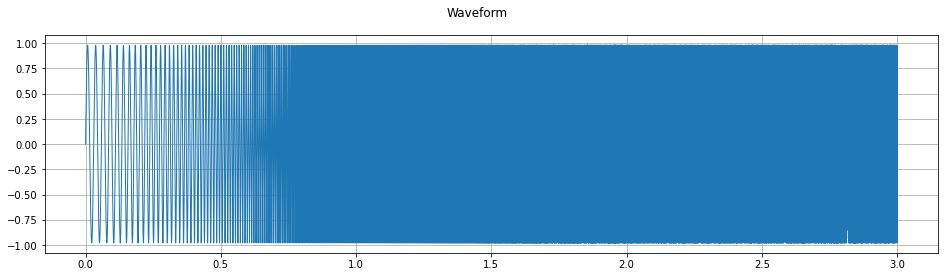

In [9]:
plot_waveform(dry_signal,samplerate_dry)

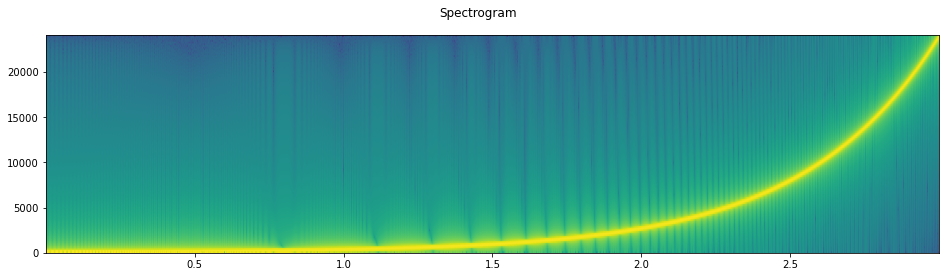

In [10]:
plot_specgram(dry_signal,samplerate_dry)

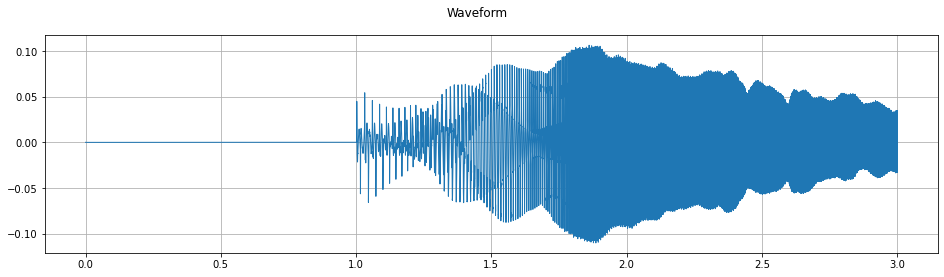

In [11]:
plot_waveform(wet_signal,samplerate_wet)

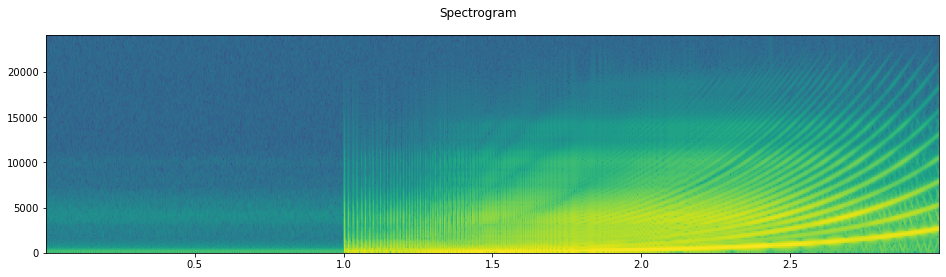

In [12]:
plot_specgram(wet_signal,samplerate_wet)

### Transformation to frequency

In [13]:
#FFT parameters

# buffer size (number of samples)
buffer = 256

# step size
my_step = int(buffer / 16)

fft_transformer = T.Spectrogram(n_fft = buffer, hop_length = 64, power = None, return_complex=True)

In [14]:
dry_signal_fft = fft_transformer(dry_signal)
dry_signal_fft.shape

torch.Size([1, 129, 2251])

In [15]:
wet_signal_fft = fft_transformer(wet_signal)
wet_signal_fft.shape

torch.Size([1, 129, 2251])

In [16]:
second_dim = len(dry_signal_fft[0])
third_dim = len(dry_signal_fft[0,0])

dry_signal_fft_mag = torch.zeros(1,second_dim,third_dim)
dry_signal_fft_angle = torch.zeros(1,second_dim,third_dim)

wet_signal_fft_mag = torch.zeros(1,second_dim,third_dim)
wet_signal_fft_angle = torch.zeros(1,second_dim,third_dim)

for i0 in range (0,third_dim):
    
    for i1 in range (0,second_dim):
        #magnitude
        dry_signal_fft_mag[0,i1,i0] = np.abs(dry_signal_fft[0,i1,i0])
        wet_signal_fft_mag[0,i1,i0] = np.abs(wet_signal_fft[0,i1,i0])
        
        #phase
        dry_signal_fft_angle[0,i1,i0] = np.angle(dry_signal_fft[0,i1,i0]).item()
        wet_signal_fft_angle[0,i1,i0] = np.angle(wet_signal_fft[0,i1,i0]).item()

## Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [18]:
torch.cuda.is_available()

True

In [19]:
class My_amp_CNN_mag(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv1d(1,64,3,1,1)
        self.conv2 = nn.Conv1d(64,128,3,1,1)
        self.conv3 = nn.Conv1d(128,64,3,1,1)
        self.fc1 = nn.Linear(64*129,4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024,129)
        
    
    def forward(self,X):
        
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = X.view(-1,64*129)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        X = X.view(-1,1,129)
        
        return X
# ==============================================================================================    

class My_amp_CNN_angle(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv1d(1,64,3,1,1)
        self.conv2 = nn.Conv1d(64,128,3,1,1)
        self.conv3 = nn.Conv1d(128,64,3,1,1)
        self.fc1 = nn.Linear(64*129,4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024,129)
        
    
    def forward(self,X):
        
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = X.view(-1,64*129)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        X = X.view(-1,1,129)
        
        return X 

In [20]:
torch.manual_seed(42)

model_mag = My_amp_CNN_mag()
model_mag = model_mag.cuda()

model_angle = My_amp_CNN_angle()
model_angle = model_angle.cuda()

#model.load_state_dict(torch.load('my_amp_vox.pt'))

In [21]:
next(model_mag.parameters()).is_cuda

True

In [22]:
next(model_angle.parameters()).is_cuda

True

In [23]:
total_params = 0
for p in model_mag.parameters():
    total_params += p.numel()

print(total_params)

38197825


In [24]:
total_params = 0
for p in model_angle.parameters():
    total_params += p.numel()

print(total_params)

38197825


## Train/test split (no scikit)

In [25]:
X_mag = dry_signal_fft_mag
X_mag = X_mag.permute(2,0,1)

X_angle = dry_signal_fft_angle
X_angle = X_angle.permute(2,0,1)

y_mag = wet_signal_fft_mag
y_mag = y_mag.permute(2,0,1)

y_angle = wet_signal_fft_angle
y_angle = y_angle.permute(2,0,1)

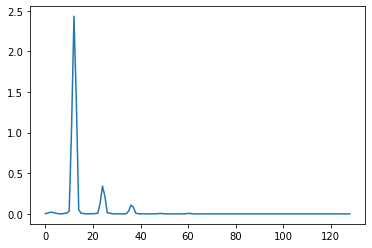

In [26]:
#plt.plot(X[2200,0,:])
plt.plot(y_mag[2200,0,:])

## Train/test split

In [27]:
X_mag = X_mag.cuda()
X_angle = X_angle.cuda()
y_mag = y_mag.cuda()
y_angle = y_angle.cuda()

## Model training

In [52]:
criterion_mag = nn.MSELoss()
optimizer_mag = torch.optim.Adam(model_mag.parameters(), lr=0.0001)

criterion_angle = nn.MSELoss()
optimizer_angle = torch.optim.Adam(model_angle.parameters(), lr=0.0001)

In [55]:
import time

epochs = 50
batches = 10
batch_size = int(X_mag.shape[0]//batches)

start_time = time.time()

model_mag.load_state_dict(torch.load('my_amp_vox_mag.pt'))
model_angle.load_state_dict(torch.load('my_amp_vox_angle.pt'))

print('######### Magnitude - training #########')

for i in range(epochs):
    
    for b in range(0,batches):
        
        y_pred = model_mag(X_mag[0+int(b*batch_size) : batch_size+int(b*batch_size)])
        loss_train = torch.sqrt(criterion_mag(y_pred, y_mag[0+int(b*batch_size) : batch_size+int(b*batch_size)]))

        optimizer_mag.zero_grad()
        loss_train.backward()
        optimizer_mag.step()
        
    if i%25 == 0:
        print(f'Epoch: {i} loss =  {loss_train.item():10.8f}')
        
    i += 1
        
stop_time = time.time() - start_time

print(f'Total time: {stop_time} seconds')

# ===============================================================================================================

print('######### Angle - training #########')

for i in range(epochs):
    
    i += 1
    
    for b in range(0,batches):
        
        y_pred = model_angle(X_angle[0+int(b*batch_size) : batch_size+int(b*batch_size)])
        loss_train = torch.sqrt(criterion_angle(y_pred, y_angle[0+int(b*batch_size) : batch_size+int(b*batch_size)]))

        optimizer_angle.zero_grad()
        loss_train.backward()
        optimizer_angle.step()
        
    if i%25 == 0:
        print(f'Epoch: {i} loss =  {loss_train.item():10.8f}')
        
    
        
stop_time = time.time() - start_time

print(f'Total time: {stop_time} seconds')

######### Magnitude - training #########
Epoch: 0 loss =  0.01226161
Epoch: 25 loss =  0.00802746
Total time: 60.56299376487732 seconds
######### Angle - training #########
Epoch: 25 loss =  0.05837929
Epoch: 50 loss =  0.05005116
Total time: 122.47605013847351 seconds


In [56]:
torch.save(model_mag.state_dict(), 'my_amp_vox_mag.pt')
torch.save(model_angle.state_dict(), 'my_amp_vox_angle.pt')

## Loss visualization (optional)

In [57]:
#plt.plot(range(epochs), losses_train)
#plt.ylabel('Loss')
#plt.xlabel('epoch');

## Model evaluation

In [58]:
'''
# on the test set

with torch.no_grad():

    y_val = model.forward(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))

print(f'{loss:.8f}')
'''

"\n# on the test set\n\nwith torch.no_grad():\n\n    y_val = model.forward(X_test)\n    loss = torch.sqrt(criterion(y_val, y_test))\n\nprint(f'{loss:.8f}')\n"

## Dry singnal -> trained model (frequency domain) -> IFFT (time domain)

In [88]:
fft_transformer_eval = T.Spectrogram(n_fft = buffer, hop_length = buffer, power = None, return_complex=True)

dry_signal_test, samplerate_test = torchaudio.load('Audio files/ARCHIV/01_guitar_dry_01_.wav')

dry_signal_fft = fft_transformer_eval(dry_signal_test)

second_dim = len(dry_signal_fft[0])
third_dim = len(dry_signal_fft[0,0])

dry_signal_fft_mag = torch.zeros(1,second_dim,third_dim)
dry_signal_fft_angle = torch.zeros(1,second_dim,third_dim)


for i0 in range (0,third_dim):
    
    for i1 in range (0,second_dim):
        #magnitude
        dry_signal_fft_mag[0,i1,i0] = np.abs(dry_signal_fft[0,i1,i0])
        
        #phase
        dry_signal_fft_angle[0,i1,i0] = np.angle(dry_signal_fft[0,i1,i0]).item()

In [89]:
dry_signal_fft_mag = dry_signal_fft_mag.permute(2,0,1)
dry_signal_fft_mag = dry_signal_fft_mag.cuda()

dry_signal_fft_angle = dry_signal_fft_angle.permute(2,0,1)
dry_signal_fft_angle = dry_signal_fft_angle.cuda()

In [90]:
dry_signal_fft_angle.shape

torch.Size([2145, 1, 129])

In [91]:
dry_signal_fft_mag.shape

torch.Size([2145, 1, 129])

In [92]:

with torch.no_grad():
    y_val_mag = model_mag.forward(dry_signal_fft_mag)
    y_val_angle = model_angle.forward(dry_signal_fft_angle)



# comlex numbers --> from modulus,argument represenation TO a + j*b

import math
import cmath

modulus_buffer = y_val_mag
argument_buffer = y_val_angle

def P2R(radii, angles):
    return radii * cmath.exp(1j*angles)

output_fft = []

for i0 in range(0,third_dim):
    
    out = []
    
    for i1 in range(0,second_dim):
        
        mag = modulus_buffer[i0,0,i1].item()
        arg = argument_buffer[i0,0,i1].item()
        out.append(P2R(mag,arg))
        
    output_fft.append(out)
    
output_fft = np.array(output_fft)



# dry signal processed through trained model - from frequency to time domain transformation

processed_signal = np.fft.irfft(output_fft)
processed_signal = np.array(processed_signal)
processed_signal = processed_signal.flatten()

#'''

In [93]:
processed_signal.shape

(549120,)

In [94]:
processed_signal.shape

(549120,)

In [95]:
output_fft.shape

(2145, 129)

### Visualization (processed vs wet signal)

In [96]:
processed_signal_tensor = torch.zeros(1, len(processed_signal))
processed_signal_tensor[0,:] = torch.Tensor(processed_signal)

In [97]:
processed_signal_tensor.shape

torch.Size([1, 549120])

In [98]:
my_file_name = 'processed_sweep.wav'

In [99]:
torchaudio.save(my_file_name,processed_signal_tensor,samplerate_dry)

In [100]:
processed_waveform, processed_samplerate = torchaudio.load(my_file_name)

In [101]:
play_audio(processed_waveform,processed_samplerate)

In [102]:
play_audio(wet_signal,samplerate_wet)

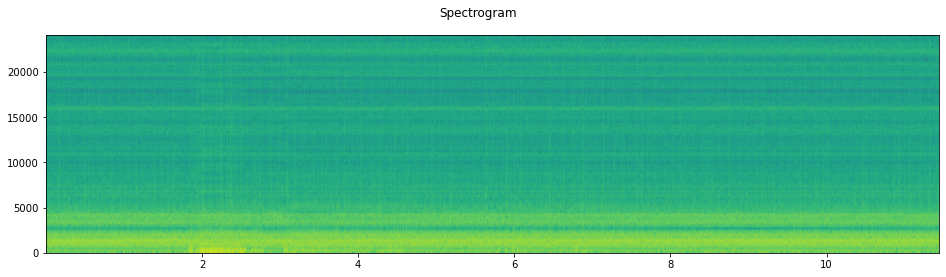

In [103]:
plot_specgram(processed_waveform,processed_samplerate)

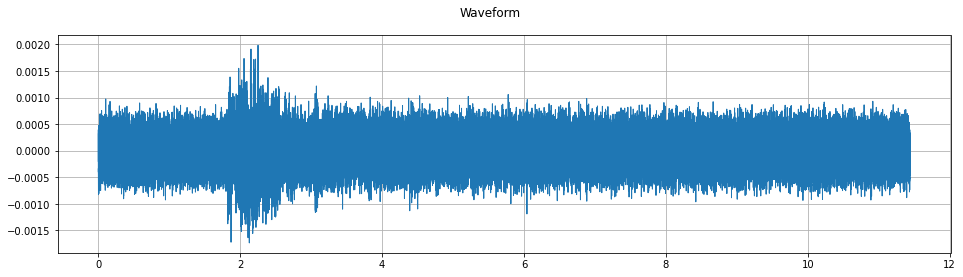

In [104]:
plot_waveform(processed_waveform,processed_samplerate)